# NAML 1st call - 16/01/2025
by Paolo Ginefra (10765882)

## Exercise 1

### Loading the data

In [5]:
import scipy.io as sio
data = sio.loadmat('faces.mat')
X = data['X']
print(X.shape)

(5000, 1024)


### Plotting a face

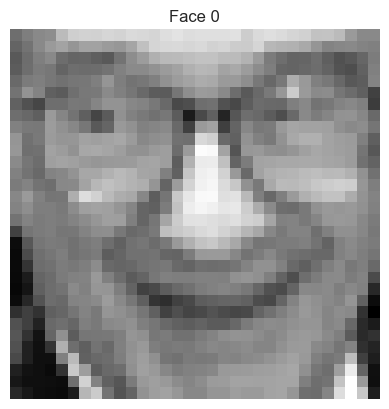

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

def plot_face(x, title=None, show=True, ax = None):
    if(ax is None):
        ax = plt
        if(title):
            ax.title(title)
    else:
        if(title):
            ax.set_title(title)
    x = np.transpose(np.reshape(x,(32,32)))
    ax.imshow(x,cmap='gray')
    ax.axis('off')
    if(show):
        plt.show()

plot_face(X[0,:], 'Face 0')

### 1.1 - Compute the normalized matrix $\tilde{X}$

In [22]:
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean
X_std = np.std(X_centered, axis=0)
X_normalized = X_centered / X_std

print(f'Mean of X_normalized: {np.mean(X_normalized)}')
print(f'Std of X_normalized: {np.std(X_normalized)}')

Mean of X_normalized: -7.128325707483896e-18
Std of X_normalized: 1.0


### 1.2 - Perform the PCA on $\tilde{X}$ and plot the first 25 eigenfaces.

In [17]:
# Compute The SVD
U, s, Vt = np.linalg.svd(X_normalized, full_matrices=False)

print(f'U shape: {U.shape}')
print(f's shape: {s.shape}')
print(f'Vt shape: {Vt.shape}')

U shape: (5000, 1024)
s shape: (1024,)
Vt shape: (1024, 1024)


> **Comment**: since the data is shaped as datapoints x features the eigenfaces are the columns of the matrix $V$.

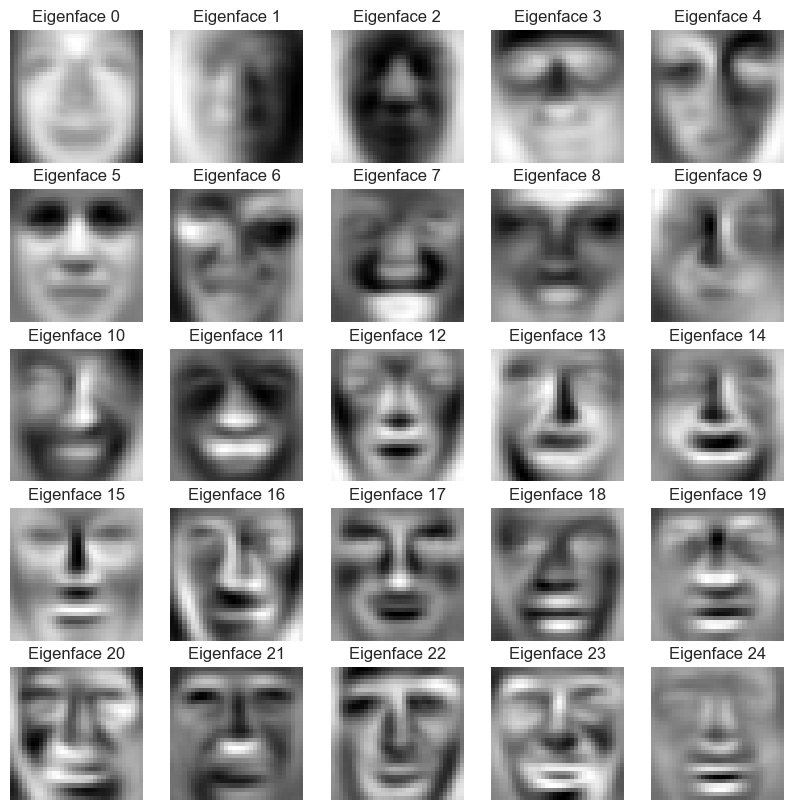

In [ ]:
# Plot the first 25 eigenfaces
n_eigenfaces = 25

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i in range(n_eigenfaces):
    ax = axs[i // 5, i % 5]
    plot_face(Vt[i, :], f'Eigenface {i}', show=False, ax=ax)

plt.show()

### 1.3 - Reduce the dimension of the sample from 1024 (32 by 32) to 100 by projecting the matrix $\tilde{X}$ onto $U$

> **Comment**: In this case I reduce the dimentions by projecting the data onto the first 100 principal directions that are the first 100 comlumns of V.

In [18]:
reduced_dimentions = 100

X_reduced = np.dot(X_normalized, Vt[:reduced_dimentions, :].T)

print(f'X_reduced shape: {X_reduced.shape}')

X_reduced shape: (5000, 100)


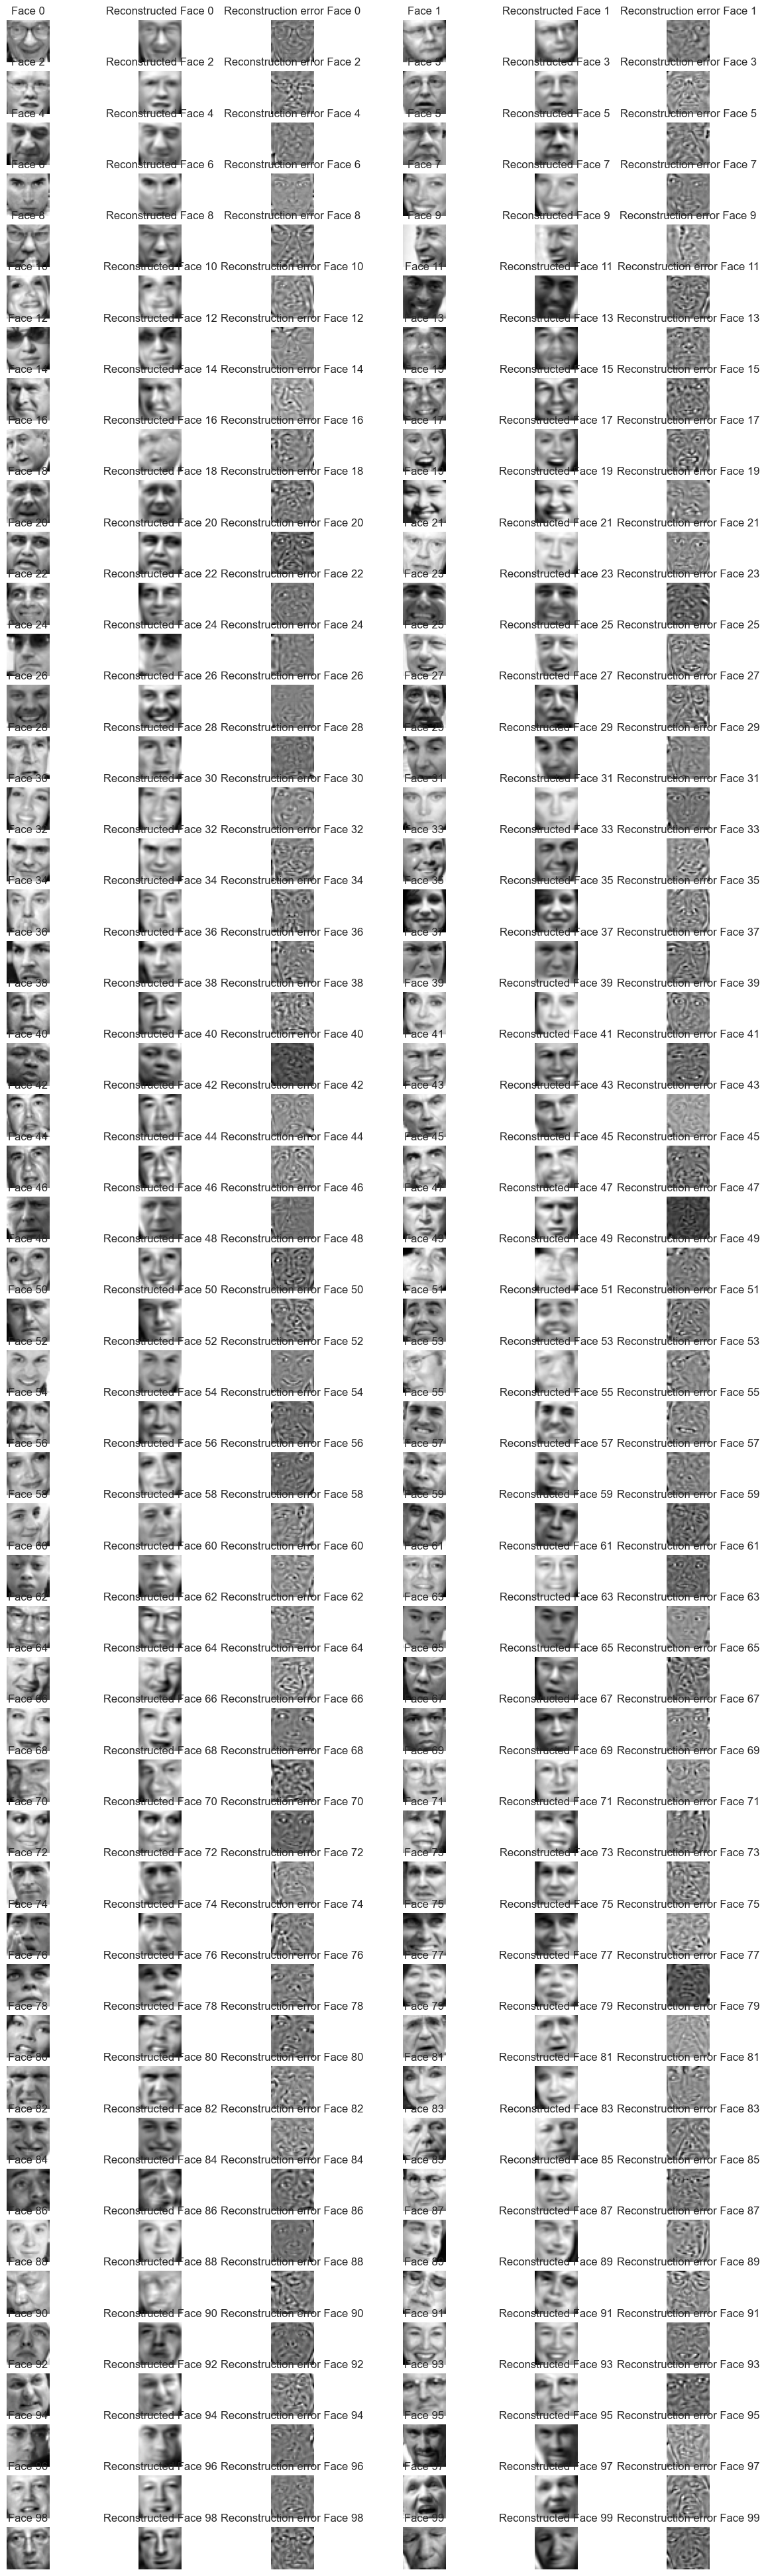

In [ ]:
%matplotlib inline
faces_to_plot = 100

fig, axs = plt.subplots(faces_to_plot//2, 6, figsize=(15, 50))

# In order to plot the recunstruction I need to reup the dimentions of the reduced X and undo the normalization
# I am computing a low rank approximation of X
reconstructed_images = np.dot(X_reduced, Vt[:reduced_dimentions, :]) * X_std + X_mean

reconstruction_error = X - reconstructed_images

for i in range(faces_to_plot):
    #original image plot
    ax = axs[i//2, 0 + 3*(i%2)]
    plot_face(X[i, :], f'Face {i}', show=False, ax=ax)

    #reconstructed image plot
    ax = axs[i//2, 1 + 3*(i%2)]
    plot_face(reconstructed_images[i, :], f'Reconstructed Face {i}', show=False, ax=ax)

    #difference plot
    ax = axs[i//2, 2+ 3*(i%2)]
    plot_face(reconstruction_error[i, :], f'Reconstruction error Face {i}', show=False, ax=ax)

plt.show()

> **Comment**: As expected the reconstruction error seems to highlight samller high frequency details.

## Exercise 2

In [38]:
import jax.numpy as jnp
import jax

### 2.1 -  Rewrite equation (2) as J(w) = 1 2wTAw +dTw+c (write explicitly A, d and c.).

In [44]:
#Data definition
x1, y1 = (2, 0.5)
x2, y2 = (-1, 0)

v1 = jnp.array([x1, 1])[:, None]
v2 = jnp.array([x2, 1])[:, None]

A = 2 * (v1 @ v1.T + v2 @ v2.T)
d = -2 * (y1 * v1 + y2 * v2)
c = (y1 ** 2 + y2 ** 2)

print('A matrix:\n', A)
print('d vector:\n', d)
print('c scalar:\n', c)

A matrix:
 [[10  2]
 [ 2  4]]
d vector:
 [[-2.]
 [-1.]]
c scalar:
 0.25


In [65]:
@jax.jit
def J(w):
    return 0.5 * w.T @ A @ w + d.T @ w + c

### 2.2 -  Compute the value of the exact parameter vector w∗ that minimize J(w)

In [63]:
w_star = jnp.linalg.solve(A, -d)
print('w_star:\n', w_star)
print(f'J(w_star): {J(w_star)}')

w_star:
 [[0.16666667]
 [0.16666669]]
J(w_star): [[2.9802322e-08]]


### 2.3 - Plot the surface that represents J.

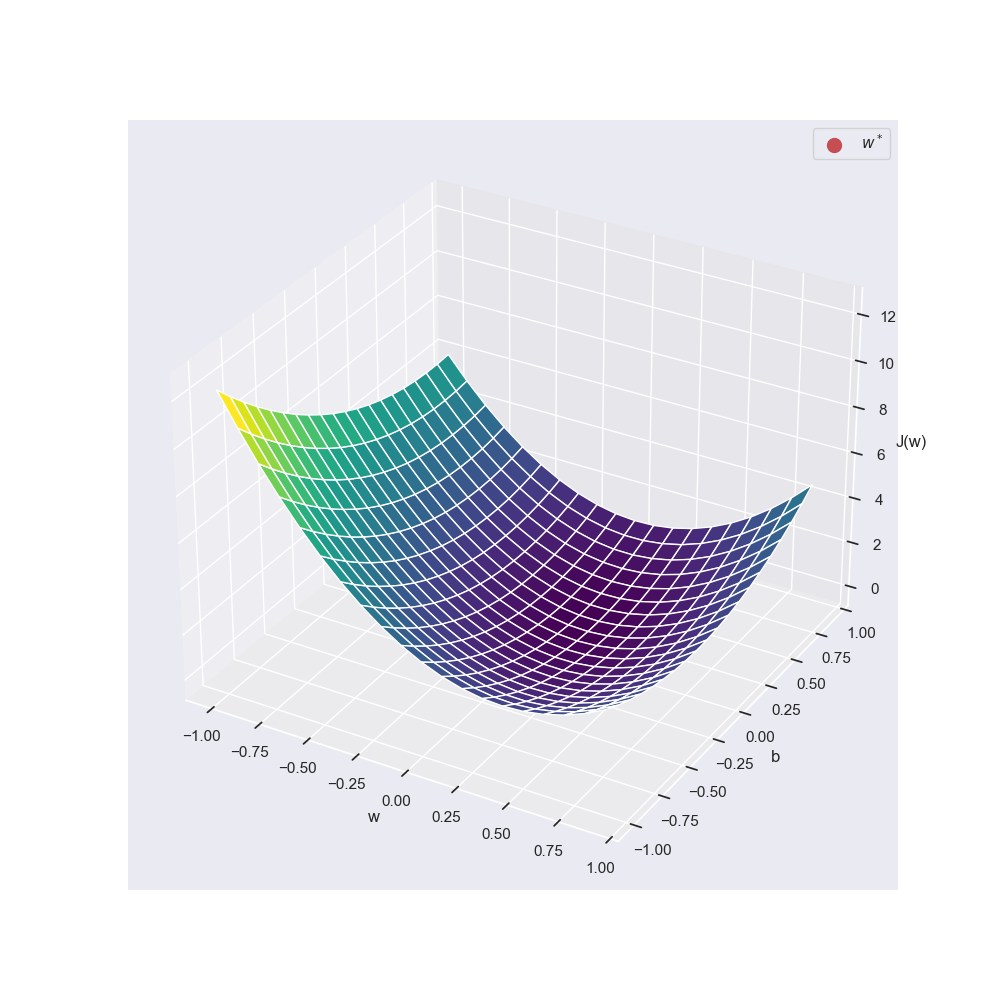

In [66]:
%matplotlib widget
#3d surface plot of J(w)
w_ = jnp.arange(-1, 1, 0.1)
b_ = jnp.arange(-1, 1, 0.1)
w_, b_ = jnp.meshgrid(w_, b_)

J_ = np.zeros_like(w_)

for i in range(w_.shape[0]):
    for j in range(w_.shape[1]):
        w = jnp.array([w_[i, j], b_[i, j]])[:, None]
        J_[i, j] = J(w)[0, 0]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(w_, b_, J_, cmap='viridis')
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('J(w)')

#mark the minimum
ax.scatter(w_star[0], w_star[1], J(w_star), color='r', s=100, label='$w^*$')
plt.legend()
plt.show()

### 2.4 - Implement the gradient descent method and use it to compute w∗: set the initial guess w(0) equal to [1, 1]T and the learning rate η equal to 0.05.

In [142]:
def compute_w(w = jnp.array([1, 1])[:, None], η = 0.05, max_iterations = 1000, ε = 1e-6):
    history = [[w, J(w)]]

    for i in range(max_iterations):
        w_new = w - η * (A @ w + d)
        if jnp.linalg.norm(w_new - w) < ε:
            print(f'Converged after {i} iterations, stopping')
            break
        J_new = J(w_new)
        history.append([w_new, J_new])
        print(f'Iteration {i}: J(w) = {J_new}, w = {w_new.T}')
        w = w_new

    return w, history

w, history = compute_w()

Iteration 0: J(w) = [[1.625]], w = [[0.5  0.75]]
Iteration 1: J(w) = [[0.5281249]], w = [[0.27499998 0.6       ]]
Iteration 2: J(w) = [[0.23343122]], w = [[0.17749998 0.5025    ]]
Iteration 3: J(w) = [[0.13209465]], w = [[0.13849999 0.43425   ]]
Iteration 4: J(w) = [[0.08470121]], w = [[0.12582499 0.38355   ]]
Iteration 5: J(w) = [[0.05698651]], w = [[0.1245575 0.3442575]]
Iteration 6: J(w) = [[0.03897467]], w = [[0.127853   0.31295025]]
Iteration 7: J(w) = [[0.02679929]], w = [[0.13263148 0.2875749 ]]
Iteration 8: J(w) = [[0.01845932]], w = [[0.13755825 0.26679677]]
Iteration 9: J(w) = [[0.01272181]], w = [[0.14209945 0.24968159]]
Iteration 10: J(w) = [[0.00876918]], w = [[0.14608157 0.23553532]]
Iteration 11: J(w) = [[0.00604497]], w = [[0.14948726 0.2238201 ]]
Iteration 12: J(w) = [[0.00416714]], w = [[0.15236162 0.21410736]]
Iteration 13: J(w) = [[0.00287266]], w = [[0.15477008 0.20604973]]
Iteration 14: J(w) = [[0.00198029]], w = [[0.15678006 0.19936277]]
Iteration 15: J(w) = [[0.

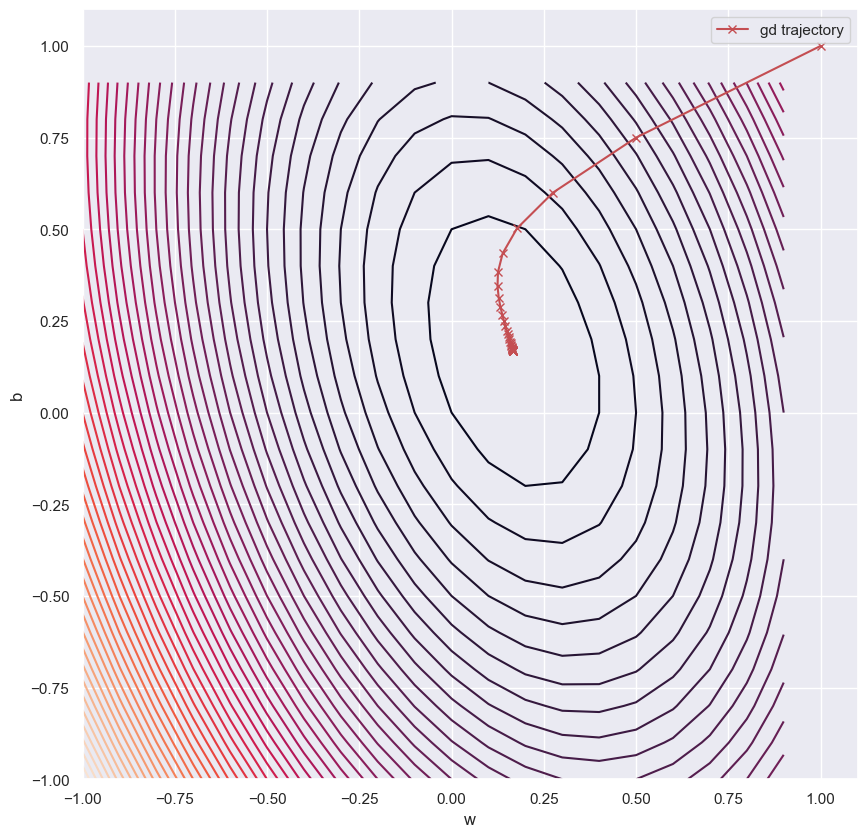

In [143]:
#plot the trajectory of w in a contour plot of J(w)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.contour(w_, b_, J_, levels=50)
ax.set_xlabel('w')
ax.set_ylabel('b')

history_ws = np.array([h[0] for h in history])
#plot with xs
ax.plot(history_ws[:, 0], history_ws[:, 1], 'rx-', label='gd trajectory')
plt.legend()
plt.show()


### 2.5 - What is the maximum value of the learning rate that can be used ?

In [151]:
# eiganval of A
eigenvalues = np.linalg.eigvals(A)
print(f'Eigenvalues of A: {eigenvalues}')

max_eiganvalue = np.max(eigenvalues)

max_η = 2 / max_eiganvalue
print(f'Maximum η: {max_η}')

Eigenvalues of A: [10.60555128  3.39444872]
Maximum η: 0.18858048469644506


Iteration 0: J(w) = [[5.673624]], w = [[-0.8758048   0.06209761]]
Iteration 1: J(w) = [[5.4952602]], w = [[1.1188985 0.5316527]]
Iteration 2: J(w) = [[5.3715763]], w = [[-0.80423117 -0.09944451]]
Iteration 3: J(w) = [[5.257222]], w = [[1.1168182  0.46446753]]
Iteration 4: J(w) = [[5.1461678]], w = [[-0.7772039  -0.11543876]]
Iteration 5: J(w) = [[5.037574]], w = [[1.0991482  0.45033455]]
Iteration 6: J(w) = [[4.9312854]], w = [[-0.7564262  -0.11233836]]
Iteration 7: J(w) = [[4.827241]], w = [[1.0797876  0.44331366]]
Iteration 8: J(w) = [[4.7253923]], w = [[-0.7368362  -0.10682797]]
Iteration 9: J(w) = [[4.6256924]], w = [[1.0605633  0.43734008]]
Iteration 10: J(w) = [[4.528096]], w = [[-0.7177584  -0.10110724]]
Iteration 11: J(w) = [[4.432561]], w = [[1.0417088  0.43161118]]
Iteration 12: J(w) = [[4.3390393]], w = [[-0.6990963  -0.09546417]]
Iteration 13: J(w) = [[4.247491]], w = [[1.0232472  0.42601883]]
Iteration 14: J(w) = [[4.157874]], w = [[-0.6808295  -0.08993435]]
Iteration 15: 

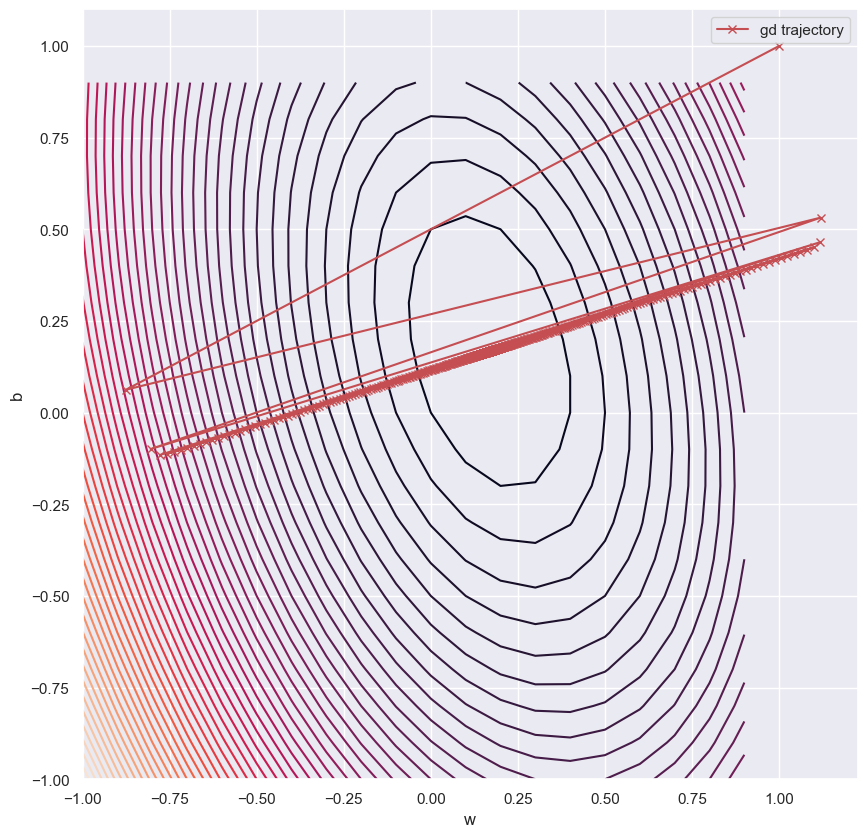

In [ ]:
# Check if it still converges with a bit less than the maximum η
w_max, history_max = compute_w(η=max_η-0.001, max_iterations=10000)

#plot the trajectory of w in a contour plot of J(w)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.contour(w_, b_, J_, levels=50)
ax.set_xlabel('w')
ax.set_ylabel('b')

history_ws = np.array([h[0] for h in history_max])
#plot with xs
ax.plot(history_ws[:, 0], history_ws[:, 1], 'rx-', label='gd trajectory')
plt.legend()
plt.show()

## Exercise 3

### Data definition

In [90]:
set1 = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [0, -1, 0],
    [-1, 0, 1],
    [0, 1, 1]
]
)

set1_x = set1[:, 0:2]
set1_y = set1[:, 2]

set2 = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [-1, 0, 0],
    [1, 0, 1],
    [0, -1, 1],
])

set2_x = set2[:, 0:2]
set2_y = set2[:, 2]

set3 = np.array([
    [0, 0, 1],
    [1, 0, 0],
    [0, 1, 0],
    [-1, 0, 0],
    [0, -1, 0]
])

set3_x = set3[:, 0:2]
set3_y = set3[:, 2]

In [102]:
def σ(z):
    return 1 / (1 + jnp.exp(-z))

def σ_vec(beta, x):
    x_ = np.array([1, x[0][0], x[1][0]])[:, None]
    return σ(beta.T @ x_)

In [103]:
beta = jnp.array([1, 1, 1])[:, None]

σ_vec(beta, set1_x[0][:,None])

Array([[0.7310586]], dtype=float32)

### 3.1 - Plot in 3 pictures the data contained in the 3 datasets (use different colors or symbols for the two classes).

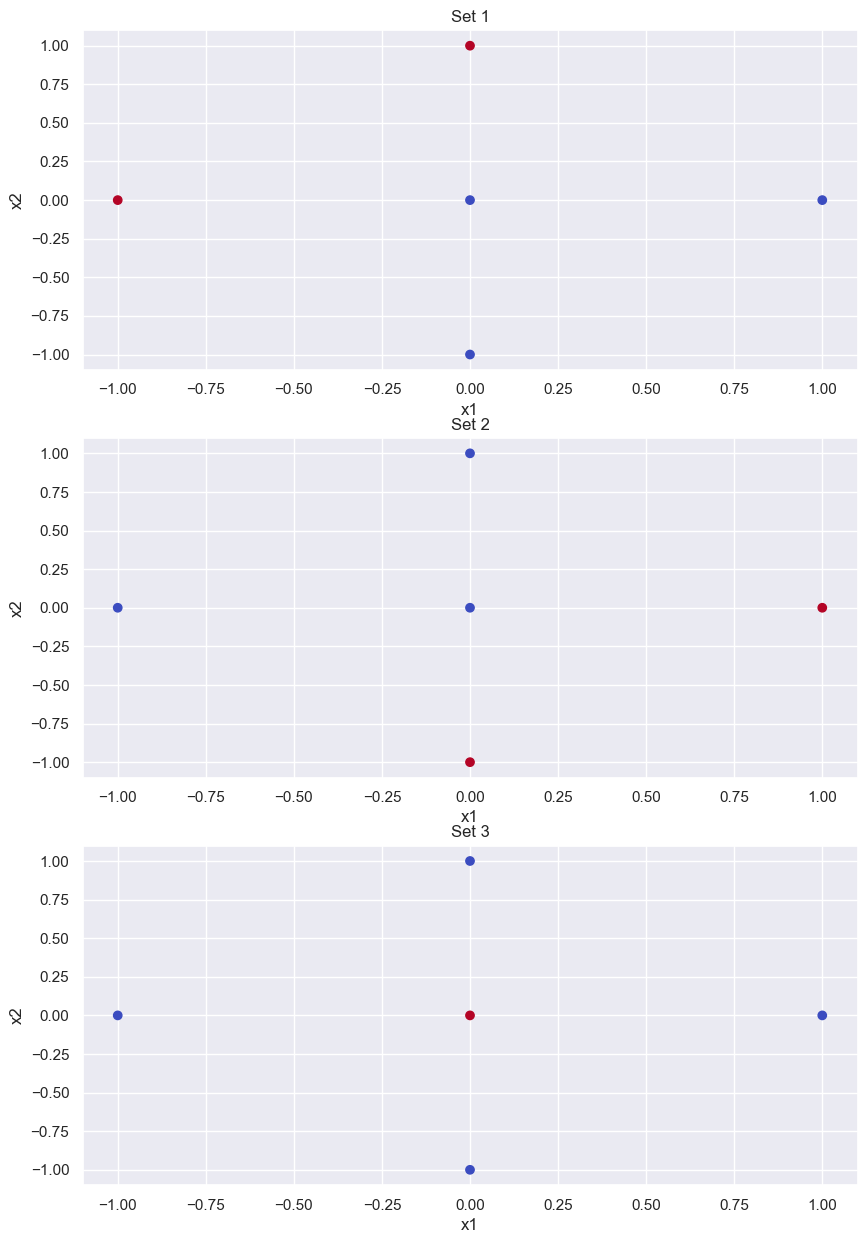

In [145]:
%matplotlib inline
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, (x, y) in enumerate(zip([set1_x, set2_x, set3_x], [set1_y, set2_y, set3_y])):
    ax = axs[i]
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(f'Set {i+1}')

plt.show()

> **Comment**: The main difference is that Set 1 and 2 are linearly separable, while set 3 is not

### 3.2 - Compute the vectors β that allow to use (3) to classify the data contained in set 1 and set 2 assuming a threshold ϵ = 0.5 for the positive class. Is the solution unique ? Motivate your answer.

In [146]:
def J_logistic(beta, x, y):
    n = len(y)
    J = 0
    for i in range(n):
        x_ = np.array([1, x[i][0], x[i][1]])[:, None]
        J += -y[i] * jnp.log(σ(beta.T @ x_)) - (1 - y[i]) * jnp.log(1 - σ(beta.T @ x_))
    return J

def gradient_J_logistic(beta, x, y):
    n = len(y)
    grad_J = jnp.zeros_like(beta)
    for i in range(n):
        x_ = np.array([1, x[i][0], x[i][1]])[:, None]
        grad_J += (σ(beta.T @ x_) - y[i]) * x_
    return grad_J

def computeBeta(x, y, η=0.1, ε=1e-6, max_iterations=1000):
    beta = jnp.array([1, 1, 1])[:, None]
    history = [[beta, J_logistic(beta, x, y)]]

    for i in range(max_iterations):
        grad_J = gradient_J_logistic(beta, x, y)
        beta_new = beta - η * grad_J
        if jnp.linalg.norm(beta_new - beta) < ε:
            print(f'Converged after {i} iterations, stopping')
            break
        J_new = J_logistic(beta_new, x, y)
        history.append([beta_new, J_new])
        print(f'Iteration {i}: J(w) = {J_new}, w = {beta_new.T}')
        beta = beta_new

    return beta, history

beta_set1, history_set1 = computeBeta(set1_x, set1_y, max_iterations=1000)
beta_set2, history_set2 = computeBeta(set2_x, set2_y, max_iterations=1000)

print(f'beta_set1: {beta_set1.T}')
print(f'beta_set2: {beta_set2.T}')


Iteration 0: J(w) = [[4.5145006]], w = [[0.8507347 0.8619203 1.0619203]]
Iteration 1: J(w) = [[4.1250954]], w = [[0.7143526  0.72692263 1.1195285 ]]
Iteration 2: J(w) = [[3.7815948]], w = [[0.5904361 0.5957432 1.1733131]]
Iteration 3: J(w) = [[3.4800634]], w = [[0.4784216 0.4690048 1.2237724]]
Iteration 4: J(w) = [[3.2163486]], w = [[0.3776233 0.3471805 1.2713739]]
Iteration 5: J(w) = [[2.986214]], w = [[0.28725672 0.23057511 1.316532  ]]
Iteration 6: J(w) = [[2.7854898]], w = [[0.20646636 0.11932772 1.3595997 ]]
Iteration 7: J(w) = [[2.6102157]], w = [[0.13435838 0.01343124 1.4008693 ]]
Iteration 8: J(w) = [[2.4567595]], w = [[ 0.07003441 -0.08723728  1.4405777 ]]
Iteration 9: J(w) = [[2.3218884]], w = [[ 0.01262222 -0.18288352  1.4789158 ]]
Iteration 10: J(w) = [[2.2027948]], w = [[-0.03870076 -0.2737651   1.5160356 ]]
Iteration 11: J(w) = [[2.0970845]], w = [[-0.08469165 -0.36016667  1.5520589 ]]
Iteration 12: J(w) = [[2.0027435]], w = [[-0.12603413 -0.4423814   1.587084  ]]
Iterati

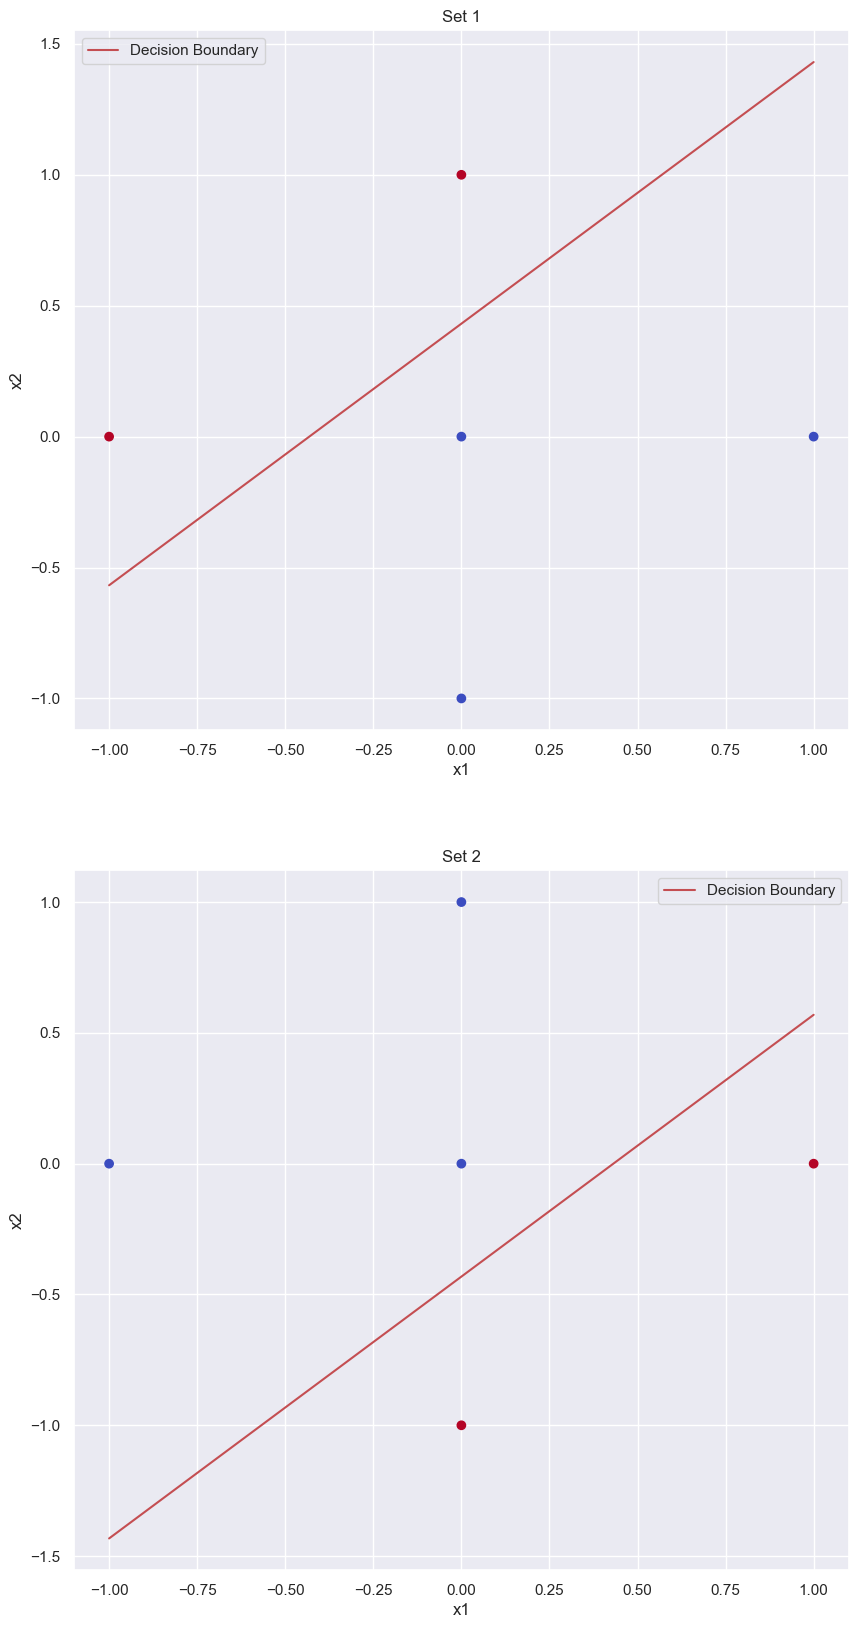

In [147]:
# plot the decision boundary
fig, axs = plt.subplots(2, 1, figsize=(10, 20))

ax1 = axs[0]
ax1.set_title('Set 1')
ax1.scatter(set1_x[:, 0], set1_x[:, 1], c=set1_y, cmap='coolwarm')
low, high = -1, 1
val_low, val_high = -(beta_set1[0] + beta_set1[1] * low) / beta_set1[2], -(beta_set1[0] + beta_set1[1] * high) / beta_set1[2]

ax1.plot([low, high], [val_low, val_high], 'r-', label='Decision Boundary')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.legend()

ax2 = axs[1]
ax2.set_title('Set 2')
ax2.scatter(set2_x[:, 0], set2_x[:, 1], c=set2_y, cmap='coolwarm')
low, high = -1, 1
val_low, val_high = -(beta_set2[0] + beta_set2[1] * low) / beta_set2[2], -(beta_set2[0] + beta_set2[1] * high) / beta_set2[2]

ax2.plot([low, high], [val_low, val_high], 'r-', label='Decision Boundary')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.legend()
plt.show()

### 3.3 -  Explain how we can use ξ1 and ξ2 to classify the data contained in set 3

In [124]:
set_3_alt = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [0, 1, 0],
    [1, 0, 0],
    [1, 0, 0]
])

set_3_alt_x = set_3_alt[:, 0:2]
set_3_alt_y = set_3_alt[:, 2]

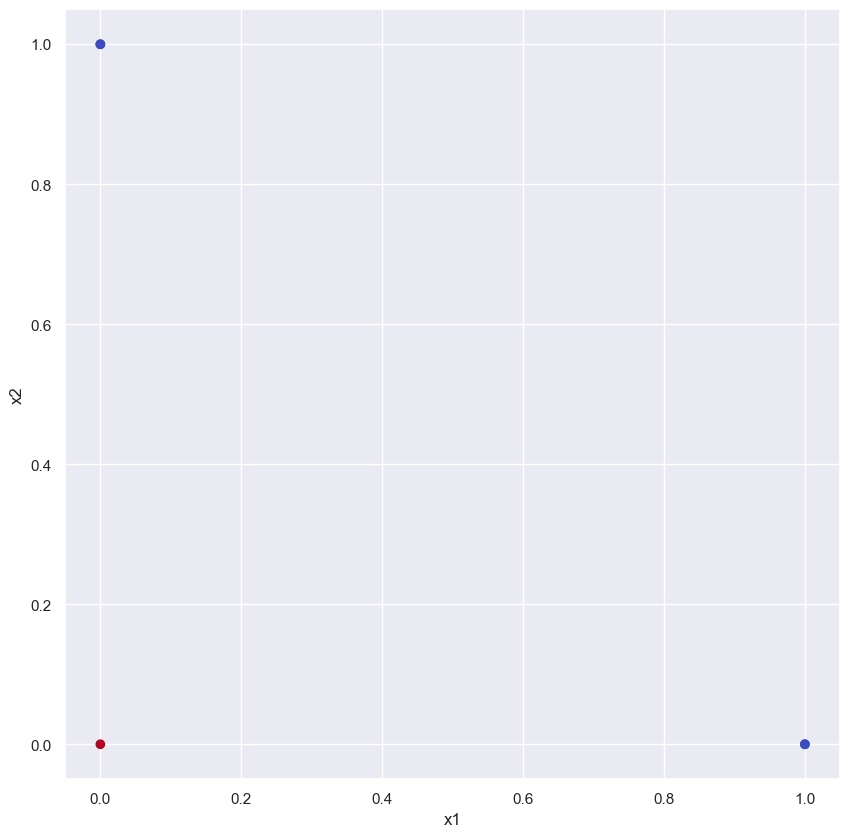

In [149]:
#plot the set 3 alt
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(set_3_alt_x[:, 0], set_3_alt_x[:, 1], c=set_3_alt_y, cmap='coolwarm')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

> *Comment*: With this new coordinate system the data is once again linearly separable so the proposed logistic regression can be used

In [126]:
beta_set3_alt, history_set3_alt = computeBeta(set_3_alt_x, set_3_alt_y, max_iterations=1000)

print(f'set3_beta_alt: {beta_set3_alt.T}')

Iteration 0: J(w) = [[7.212168]], w = [[0.6745753 0.8238406 0.8238406]]
Iteration 1: J(w) = [[5.8963714]], w = [[0.3813874 0.660373  0.660373 ]]
Iteration 2: J(w) = [[4.8829055]], w = [[0.12629083 0.5125351  0.5125351 ]]
Iteration 3: J(w) = [[4.139773]], w = [[-0.08865745  0.3816375   0.3816375 ]]
Iteration 4: J(w) = [[3.6104102]], w = [[-0.26553267  0.2670924   0.2670924 ]]
Iteration 5: J(w) = [[3.2361345]], w = [[-0.4090891   0.16701442  0.16701442]]
Iteration 6: J(w) = [[2.9691193]], w = [[-0.5249122   0.07905939  0.07905939]]
Iteration 7: J(w) = [[2.7749548]], w = [[-0.6182215   0.00098994  0.00098994]]
Iteration 8: J(w) = [[2.6302989]], w = [[-0.6934047  -0.06909233 -0.06909233]]
Iteration 9: J(w) = [[2.5196528]], w = [[-0.753974   -0.13271321 -0.13271321]]
Iteration 10: J(w) = [[2.4327314]], w = [[-0.80268717 -0.191072   -0.191072  ]]
Iteration 11: J(w) = [[2.3626447]], w = [[-0.8417004  -0.24510604 -0.24510604]]
Iteration 12: J(w) = [[2.304708]], w = [[-0.8727061  -0.29555008 -0

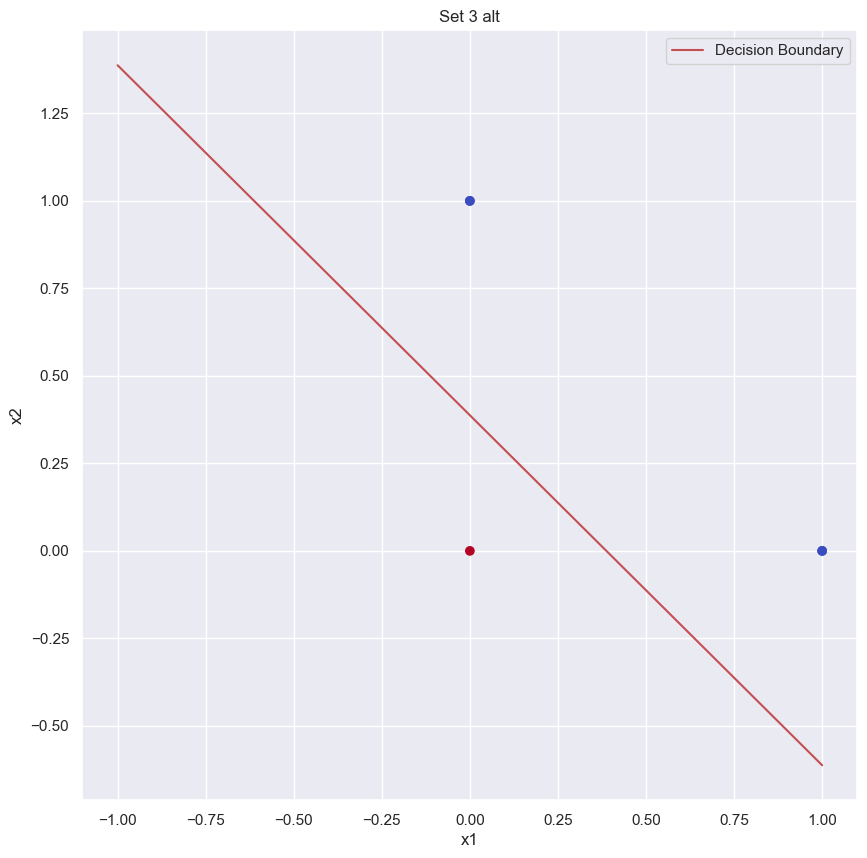

In [150]:
#plot the decision boundery of set3 alt
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Set 3 alt')
ax.scatter(set_3_alt_x[:, 0], set_3_alt_x[:, 1], c=set_3_alt_y, cmap='coolwarm')
low, high = -1, 1
val_low, val_high = -(beta_set3_alt[0] + beta_set3_alt[1] * low) / beta_set3_alt[2], -(beta_set3_alt[0] + beta_set3_alt[1] * high) / beta_set3_alt[2]

ax.plot([low, high], [val_low, val_high], 'r-', label='Decision Boundary')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend()
plt.show()